Nick Clifford

# Principal Component Anaylsis 

Next, I extract the principal components, or a reduced set of important features, of the original and modern texts from scratch. I hope to use these  components to explore the latent properties of the documents, authors, and era in which they lived in. 

# Setup

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh
from scipy.linalg import norm
import plotly_express as px

In [75]:
OHCO = 'author year doc_id'.split()

datadir = '/Users/nickclifford/Documents/UVA/Spring 2020/DS 5001 Exploratory Text Analysis/final/data/'
table_out = datadir + 'tables/'

LIB = pd.read_csv(datadir + 'tables/LIB_mod.csv', parse_dates=['date']).set_index('doc_id')
TOKEN = pd.read_csv(datadir + 'tables/TOKEN_mod.csv').set_index('doc_id')
VOCAB = pd.read_csv(datadir + 'tables/VOCAB_mod.csv').set_index('term_id')

# Generate reduced `TFIDF` Table

In [249]:
def get_TFIDF(TOKEN, VOCAB, LIB, OHCO=OHCO, bagging='doc_id', tf_method='sum', idf_method='standard', item='term_id'):
    """From TOKEN table and specified methods and OHCO bagging,
    creates a TFIDF table along with respective DTCM tables"""
    
    # add author/county/date col to token
    TOKEN = TOKEN.merge(LIB[['author', 'county', 'date']], left_index=True, right_index=True).reset_index()
    # add stem col to token
    TOKEN['year'] = TOKEN.date.dt.year
    TOKEN['month'] = TOKEN.date.dt.month
    TOKEN['stem_porter'] = TOKEN.term_id.map(VOCAB.stem_porter)

    TOKEN = TOKEN[~TOKEN.pos.str.match('NNPS?')]
    TOKEN = TOKEN.query('year != 2018')
    
    bag = OHCO[:OHCO.index(bagging) + 1]
    
    if item == 'term_str':
        BOW = TOKEN.groupby(bag+['term_str']).term_str.count()\
        .to_frame().rename(columns={'term_str':'n'})
    elif item == 'term_id':
        BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
        .to_frame().rename(columns={'term_id':'n'})
    elif item == 'stem':
        BOW = TOKEN.groupby(bag+['stem_porter']).stem_porter.count()\
        .to_frame().rename(columns={'stem_porter':'n'})
        
    BOW['c'] = BOW.n.astype('bool').astype('int')
    DTCM = BOW['n'].unstack().fillna(0).astype('int')
    
    
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)

    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    
    TF = TF.T
    DF = DTCM[DTCM > 0].count()
    N = DTCM.shape[0]
    
    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1 # Correct?

    TFIDF = TF * IDF
    
    return TFIDF, DTCM

In [250]:
TFIDF, DTCM = get_TFIDF(TOKEN, VOCAB, LIB, OHCO)

Bag at higher level

In [251]:
TFIDF = TFIDF.groupby(OHCO).mean()

Reduce `TFIDF` to the upper 80% TFIDF sum

In [252]:
sig_terms = TFIDF.sum()[TFIDF.sum() > TFIDF.sum().quantile(.80)]

In [253]:
TFIDF = TFIDF.T.loc[pd.IndexSlice[sig_terms.index.tolist()],:].T

In [254]:
TFIDF.shape

(1741, 3726)

## Normalize doc vector lengths

We use L2 normalization

In [255]:
TFIDF = TFIDF.apply(lambda x: x / np.sqrt(np.square(x).sum()), 1)

## Normalize term vector variance

We do **not** normalize variance, which we would normally do, such as with data containing divergent units of measure. \
This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s &mdash; 8m00s).

## Center the word vectors

Note that we are taking the column-wise means -- the means for the term vectors. \
We don't really need to do this. But it is typical for PCA. \
**NOTE:** Some argue that centering alters the cosine angles.

In [256]:
TFIDF = TFIDF - TFIDF.mean()

In [257]:
TFIDF.head()

,,term_id,233,567,610,673,828,1048,1191,1306,1362,1406,...,4061,7325,10921,19558,21934,5083,16341,23534,14907,20003
author,year,doc_id,,,,,,,,,,,,,,,,,,,,,
"""A deserter from the Rebel army""",1863.0,F0926,0.067383,0.066442,-0.003839,0.060992,0.237867,0.116931,-0.000358,0.003032,0.062275,-0.001529,...,-0.000261,-0.000261,-0.000261,-0.000234,-0.000234,-0.000303,-0.000308,-0.00025,-0.000264,-0.000272
(probably L. [Letitia?] R. Smiley),1866.0,A1114,-0.003993,-0.004449,0.003893,-0.004702,-0.003378,-0.006174,0.001979,-0.015295,-0.004827,0.003808,...,-0.000261,-0.000261,-0.000261,-0.000234,-0.000234,-0.000303,-0.000308,-0.00025,-0.000264,-0.000272
A Brother,1863.0,F0039,-0.003993,-0.004449,-0.001859,-0.004702,-0.003378,-0.006174,0.003544,-0.015295,-0.004827,0.005793,...,-0.000261,-0.000261,-0.000261,-0.000234,-0.000234,-0.000303,-0.000308,-0.00025,-0.000264,-0.000272
A Son,1862.0,A0547,-0.003993,-0.004449,-0.007359,-0.004702,-0.003378,-0.006174,-0.010185,-0.005128,-0.004827,-0.003071,...,-0.000261,-0.000261,-0.000261,-0.000234,-0.000234,-0.000303,-0.000308,-0.00025,-0.000264,-0.000272
A wife,1883.0,A5063,-0.003993,-0.004449,-0.002465,-0.004702,-0.003378,0.072735,-0.009288,-0.003547,-0.004827,-0.000902,...,-0.000261,-0.000261,-0.000261,-0.000234,-0.000234,-0.000303,-0.000308,-0.00025,-0.000264,-0.000272


# Compute Covariance Matrix

$n = |X| = |Y|$

$Cov(X,Y) = \dfrac{\sum_{i=1}^{n} (x_i - \mu_X) (y_i - \mu_Y)}{n - 1} = \dfrac{XY}{n-1}$

We could we use the built in Pandas method here, but compute it ourselves.

In [258]:
COV = TFIDF.T.dot(TFIDF) / (TFIDF.shape[0] - 1)

In [259]:
COV.iloc[:5,:10].style.background_gradient()

term_id,233,567,610,673,828,1048,1191,1306,1362,1406
term_id,,,,,,,,,,
233,0.000312,0.000029,0.000001,0.000021,0.000005,-0.000011,0.000004,-0.000007,0.000001,0.000004
567,0.000029,0.000393,0.000002,0.000013,0.000004,-0.000010,-0.000001,0.000002,-0.000015,0.000005
610,0.000001,0.000002,0.000025,0.000004,0.000000,-0.000003,0.000015,0.000011,0.000009,0.000012
673,0.000021,0.000013,0.000004,0.000332,0.000002,-0.000001,0.000000,-0.000009,-0.000003,0.000002
828,0.000005,0.000004,0.000000,0.000002,0.000329,0.000041,-0.000004,-0.000004,0.000009,0.000001


In [260]:
%time eig_vals, eig_vecs = eigh(COV)

CPU times: user 18.4 s, sys: 481 ms, total: 18.8 s
Wall time: 13.4 s


## Convert eigen data to dataframes

In [261]:
TERM_IDX = COV.index

In [262]:
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)

In [263]:
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'

In [264]:
EIG_VAL.iloc[:5]

,eig_val
term_id,
233,-4.126125e-18
567,-3.587491e-18
610,-3.536608e-18
673,-3.482648e-18
828,-3.201128e-18


# Select Principal Components

Next, we associate each eigenvalue with its corresponding *column* in the eigenvalue matrix. \
This is why we transpose the `EIG_VEC` dataframe.

## Combine eigenvalues and eignvectors

In [265]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [266]:
EIG_PAIRS.head()

,eig_val,233,567,610,673,828,1048,1191,1306,1362,...,4061,7325,10921,19558,21934,5083,16341,23534,14907,20003
term_id,,,,,,,,,,,,,,,,,,,,,
233,-4.126125e-18,-0.131165,0.086613,-0.533332,0.060460,-0.050981,-0.026919,-0.134043,-0.046634,0.052647,...,-0.005347,-0.004602,0.001145,0.005699,0.003345,0.003154,-0.000950,0.003850,0.003584,0.000099
567,-3.587491e-18,0.004637,0.008155,0.006724,-0.010847,0.025424,-0.009413,0.058090,0.025306,0.025978,...,-0.000618,-0.001467,-0.003289,-0.005122,-0.003443,0.006884,-0.004991,-0.003935,0.008891,-0.000778
610,-3.536608e-18,0.031000,-0.036679,0.100484,0.088176,-0.089889,-0.121725,-0.442694,-0.217050,-0.074010,...,0.001333,-0.000461,-0.000949,0.003270,0.008472,-0.006896,-0.004520,0.025093,0.006154,-0.008907
673,-3.482648e-18,0.207411,-0.002640,-0.215587,-0.170385,0.130488,-0.034208,-0.039798,-0.003589,-0.125298,...,-0.005322,-0.003027,-0.001362,-0.003283,0.000642,-0.004168,-0.012559,-0.001128,-0.019447,-0.003126
828,-3.201128e-18,0.054846,0.023600,-0.107524,-0.135128,-0.061496,-0.062953,0.012854,-0.026323,-0.027237,...,-0.000647,0.003845,0.003000,0.011783,0.012890,0.003265,0.000816,0.002521,0.000097,-0.002470


## Compute and Show Explained Variance

We might have usd this value to sort our components.

In [267]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

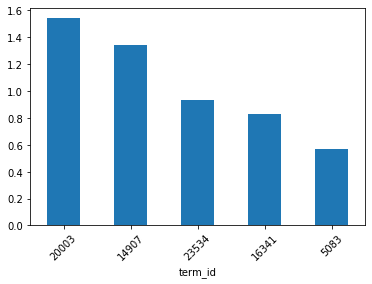

In [268]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45);

## Pick Top K (10) Components

We pick these based on explained variance.

In [269]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [270]:
COMPS

,eig_val,233,567,610,673,828,1048,1191,1306,1362,...,7325,10921,19558,21934,5083,16341,23534,14907,20003,exp_var
PC0,0.014345,-0.006767,-0.000224,0.015150,0.000846,-0.007606,-0.024386,0.060826,0.036676,-0.006431,...,-0.003243,-0.003243,-0.002653,-0.002653,-0.003645,-0.003311,-0.002396,-0.003851,-0.003589,1.54
PC1,0.012473,-0.018450,-0.030132,-0.016844,-0.006103,0.004794,0.009430,-0.018331,0.002977,-0.009083,...,0.002321,0.002321,0.001735,0.001735,0.002710,0.002919,0.002107,0.002495,0.002089,1.34
PC2,0.008643,0.006373,0.004953,0.008905,0.013646,0.020323,0.026000,-0.011368,-0.046220,0.031313,...,-0.000777,-0.000777,-0.002492,-0.002492,-0.000062,-0.001006,-0.000777,-0.000523,-0.002526,0.93
PC3,0.007666,0.006296,-0.011636,0.013804,-0.014378,0.016115,0.014393,-0.000934,0.010598,0.026483,...,-0.001926,-0.001926,-0.001387,-0.001387,-0.001671,-0.002587,-0.001940,-0.002537,-0.001922,0.83
PC4,0.005264,0.038567,0.029934,-0.007849,-0.001122,-0.025930,-0.044137,0.001461,-0.028541,-0.005298,...,0.001025,0.001025,0.002362,0.002362,-0.000297,-0.000103,0.000314,0.000711,0.001429,0.57
PC5,0.004961,0.000546,0.002726,0.001077,0.008039,0.005531,-0.004245,0.001775,0.010184,0.046558,...,-0.001310,-0.001310,-0.002672,-0.002672,-0.000584,-0.001708,-0.001784,-0.000829,-0.000156,0.53
PC6,0.004946,-0.030986,0.002150,-0.004235,-0.006729,-0.009031,-0.033679,-0.014935,-0.042867,-0.019435,...,0.001647,0.001647,0.002995,0.002995,0.001616,0.001397,0.001817,0.002909,0.003105,0.53
PC7,0.004212,-0.009882,0.004063,0.004321,0.012533,-0.005173,0.003918,0.001516,-0.030692,0.017194,...,-0.000916,-0.000916,-0.000392,-0.000392,-0.000353,-0.001880,0.000355,-0.001243,-0.000191,0.45
PC8,0.003811,0.013766,0.009306,0.001095,-0.002211,-0.023737,-0.058528,0.006806,0.047563,-0.005619,...,-0.000121,-0.000121,0.000900,0.000900,-0.001694,-0.000150,-0.002300,0.000528,0.001109,0.41
PC9,0.003336,-0.014677,0.019728,0.010087,-0.014189,-0.003486,-0.014369,-0.021823,0.001717,-0.002882,...,0.001810,0.001810,0.003648,0.003648,0.003335,0.002379,0.000303,0.002043,0.002164,0.36


# Inspect terms associated with eigenvectors

In [271]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']

term_id
20003     sobenchaur
14907       nicholas
23534       wheelers
16341        placeif
5083        construe
21934       tongsand
19558         shoval
10921    hughintends
7325     ejectmentin
4061         chambrg
Name: term_str, dtype: object

## Show Loadings

Loadings sow the contribution of each term to the component. \
We'll just look at the topi 10 words for the first two components in the Book version.

In [272]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'

In [273]:
LOADINGS.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_id,,,,,,,,,,
233,-0.006767,-0.018450,0.006373,0.006296,0.038567,0.000546,-0.030986,-0.009882,0.013766,-0.014677
567,-0.000224,-0.030132,0.004953,-0.011636,0.029934,0.002726,0.002150,0.004063,0.009306,0.019728
610,0.015150,-0.016844,0.008905,0.013804,-0.007849,0.001077,-0.004235,0.004321,0.001095,0.010087
673,0.000846,-0.006103,0.013646,-0.014378,-0.001122,0.008039,-0.006729,0.012533,-0.002211,-0.014189
828,-0.007606,0.004794,0.020323,0.016115,-0.025930,0.005531,-0.009031,-0.005173,-0.023737,-0.003486


In [274]:
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [275]:
def print_loadings(pc1, pc2, words=10):
    """Show the top words for any two components"""
    
    l0_pos = LOADINGS.sort_values(pc1, ascending=True).head(words).term_str.str.cat(sep=' ')
    l0_neg = LOADINGS.sort_values(pc1, ascending=False).head(words).term_str.str.cat(sep=' ')
    l1_pos = LOADINGS.sort_values(pc2, ascending=True).head(words).term_str.str.cat(sep=' ')
    l1_neg = LOADINGS.sort_values(pc2, ascending=False).head(words).term_str.str.cat(sep=' ')
    
    print('Letters %s+' % pc1, l0_pos)
    print('\nLetters %s-' % pc1, l0_neg)
    print('\nLetters %s+' % pc2, l1_pos)
    print('\nLetters %s-' % pc2, l1_neg)

In [276]:
print_loadings("PC0", "PC1", words=10)

Letters PC0+ respectfully honorable schools school chambersburg teachers teacher servant 1 amount

Letters PC0- love heart she her nt happy come live home tell

Letters PC1+ we enemy our wounded got they killed miles men fight

Letters PC1- love heart devotion happy live staunton truly loving ella she


# Project Docs onto New Subspace

We get the dot product of the DTM matrix and the new component matrix, which we will call DCM -- for document-component matrix. \
This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [389]:
DCM = TFIDF.dot(COMPS[TERM_IDX].T)

In [390]:
DCM = DCM.reset_index().set_index(['doc_id'])

We add metadata to our new, reduced matrices for display purposes.

In [391]:
#DCM = DCM.join(LIB[['author']], on='doc_id')

In [392]:
DCM.head()

,author,year,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
doc_id,,,,,,,,,,,,
F0926,"""A deserter from the Rebel army""",1863.0,-0.079869,0.017278,0.050262,-0.017691,-0.070817,0.027306,-0.089287,-0.008002,-0.046340,-0.025628
A1114,(probably L. [Letitia?] R. Smiley),1866.0,0.151101,-0.014737,0.043045,0.189543,0.114170,-0.048006,0.171937,-0.074295,-0.096336,-0.010629
F0039,A Brother,1863.0,-0.002533,-0.133200,-0.000356,-0.058867,0.085635,0.000958,0.023428,0.075903,-0.019022,0.116175
A0547,A Son,1862.0,-0.047041,0.025695,-0.000017,-0.017082,0.000626,0.006431,0.041331,0.017270,-0.008502,0.026796
A5063,A wife,1883.0,0.159635,0.013446,-0.051886,0.144057,0.034529,-0.076516,0.135150,-0.083196,0.012329,-0.045707


In [393]:
DCM.head().style.background_gradient()

,author,year,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
doc_id,,,,,,,,,,,,
F0926,"""A deserter from the Rebel army""",1863.000000,-0.079869,0.017278,0.050262,-0.017691,-0.070817,0.027306,-0.089287,-0.008002,-0.046340,-0.025628
A1114,(probably L. [Letitia?] R. Smiley),1866.000000,0.151101,-0.014737,0.043045,0.189543,0.114170,-0.048006,0.171937,-0.074295,-0.096336,-0.010629
F0039,A Brother,1863.000000,-0.002533,-0.133200,-0.000356,-0.058867,0.085635,0.000958,0.023428,0.075903,-0.019022,0.116175
A0547,A Son,1862.000000,-0.047041,0.025695,-0.000017,-0.017082,0.000626,0.006431,0.041331,0.017270,-0.008502,0.026796
A5063,A wife,1883.000000,0.159635,0.013446,-0.051886,0.144057,0.034529,-0.076516,0.135150,-0.083196,0.012329,-0.045707


# Reduce Authors and Years

Filter DCM by more prevalent authors (>= 30 letters) and years to only be around civil war 

In [394]:
DCM = DCM.merge(LIB.county, on='doc_id')
#DCM = DCM.query('county == "Augusta" | county == "Franklin"')

prom_authors = LIB.author.value_counts()[LIB.author.value_counts() >= 30].index
DCM_civil = DCM[DCM.author.isin(prom_authors)]
DCM_civil['year'] = DCM_civil.year.astype(int)
DCM_civil['year'] = DCM_civil.year.astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visualize

In [398]:
def vis_pcs(M, a, b, label='author', prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color=label, 
#                        hover_name='doc', 
                        marginal_x='box')
    fig.show()

## Year

Nothing really separates the document years

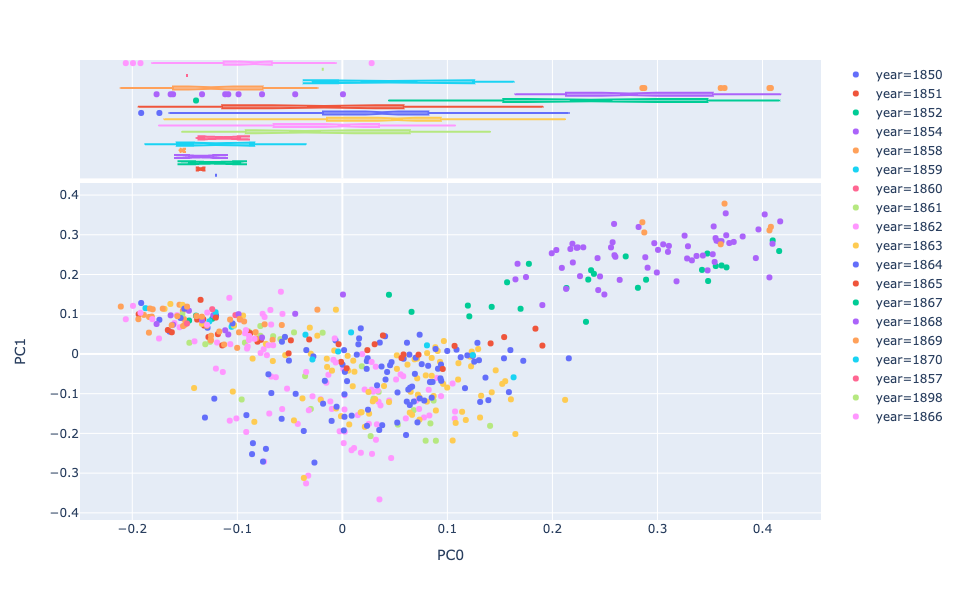

In [402]:
vis_pcs(DCM_civil, 0, 1, 'year')

In [400]:
print_loadings("PC0", "PC1", 20)

Letters PC0+ respectfully honorable schools school chambersburg teachers teacher servant 1 amount colored obedient favor against which check hereby request nomination enclosed

Letters PC0- love heart she her nt happy come live home tell how dear see devotion loving so he long did world

Letters PC1+ we enemy our wounded got they killed miles men fight river them were yankees camp back battle went army regiment

Letters PC1- love heart devotion happy live staunton truly loving ella she world yours soul respectfully unchanging her pa devotedly wish happiness


## Author

These components actually separate authors pretty well. 

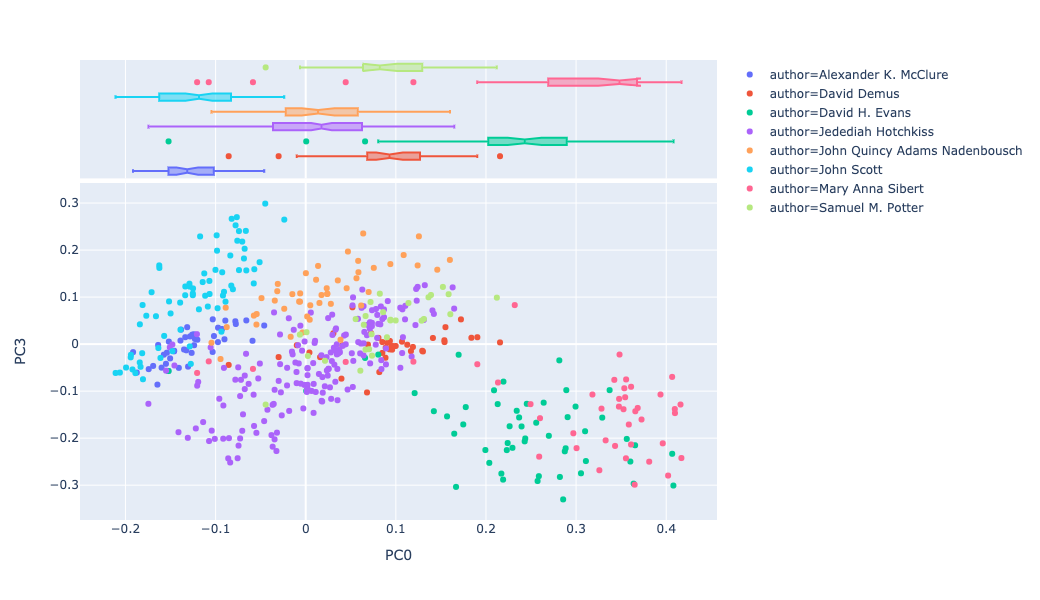

In [401]:
vis_pcs(DCM_civil, 0, 3, 'author')

In [384]:
print_loadings("PC0", "PC3", 20)

Letters PC0+ respectfully honorable schools school chambersburg teachers teacher servant 1 amount colored obedient favor against which check hereby request nomination enclosed

Letters PC0- love heart she her nt happy come live home tell how dear see devotion loving so he long did world

Letters PC3+ love heart wounded enemy killed devotion loving ella fight battle miles staunton back prisoners live bless artillery unchanging river men

Letters PC3- she her school colored people teacher house work little money children schools scholars teachers better room he has might get


## County

County also kinda gets separated but something happening with Franklin

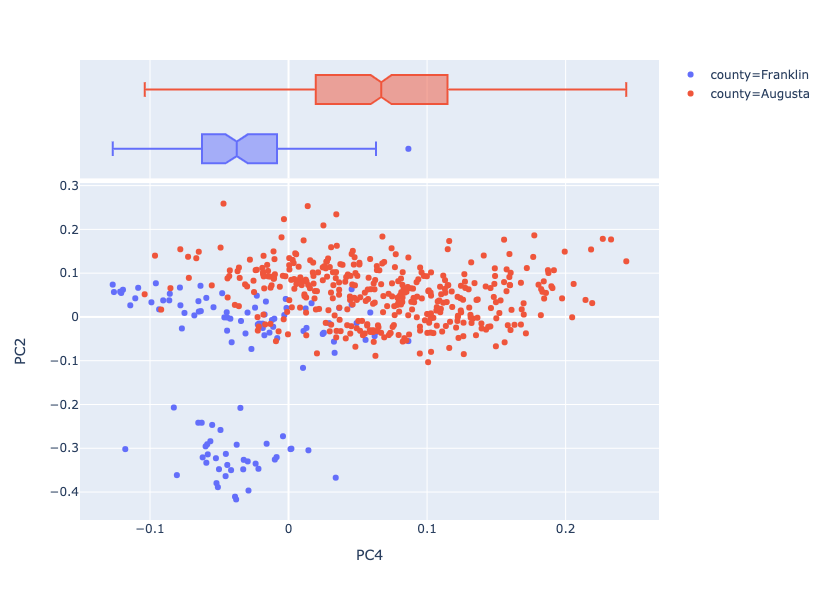

In [332]:
vis_pcs(DCM_civil, 4, 2, 'county')

In [301]:
print_loadings("PC2", "PC4", 20)

Letters PC2+ nt why lines present island got inform ca 54th get likeness tell letter health let write well please find these

Letters PC2- she enemy s school heart her were their who his upon which our people shall should though love only by

Letters PC4+ friend his friends upon present never happy should party health he feel state pleasure letter believe life our may subject

Letters PC4- school send teacher love 1 colored schools teachers she andc scholars 2 come want box books got work money up
